# LiNGAM
因果推論探索の手法の一つで、非ガウス性を利用して因果関係を推定する。


https://chatgpt.com/c/67af26c9-9a14-8006-8b68-678b4ea5a291

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lingam import DirectLiNGAM

In [28]:
from sklearn.datasets import fetch_california_housing

# データセットの取得（Bostonは非推奨なのでCalifornia Housingを使用）
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)

# 住宅価格を追加
df["PRICE"] = data.target

# 特徴量を標準化
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_scaled

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,2.129631
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,1.314156
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,1.258693
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,1.165100
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,1.172900
...,...,...,...,...,...,...,...,...,...
20635,-1.216128,-0.289187,-0.155023,0.077354,-0.512592,-0.049110,1.801647,-0.758826,-1.115804
20636,-0.691593,-0.845393,0.276881,0.462365,-0.944405,0.005021,1.806329,-0.818722,-1.124470
20637,-1.142593,-0.924851,-0.090318,0.049414,-0.369537,-0.071735,1.778237,-0.823713,-0.992746
20638,-1.054583,-0.845393,-0.040211,0.158778,-0.604429,-0.091225,1.778237,-0.873626,-1.058608


- MedInc: 地区の住民の収入の中央値
- HouseAge: 住宅の平均年数
- AveRooms: 1戸あたりの平均部屋数
- AveBedrms: 1戸あたりの平均寝室数
- Population: 地区の総人口
- AveOccup: 1戸あたりの平均居住者数
- Latitude: 地区の緯度
- Longitude: 地区の経度
- PRICE: 地区の住宅価格の中央値

<Axes: >

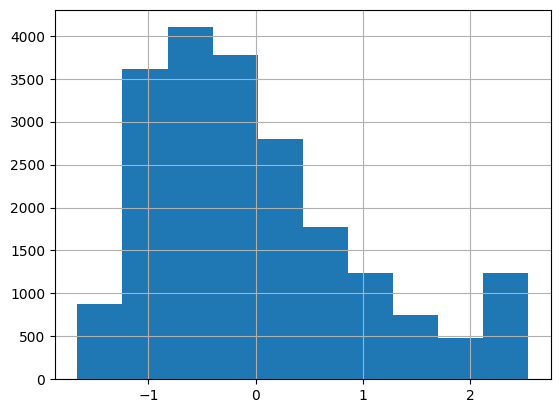

In [29]:
df_scaled['PRICE'].hist()

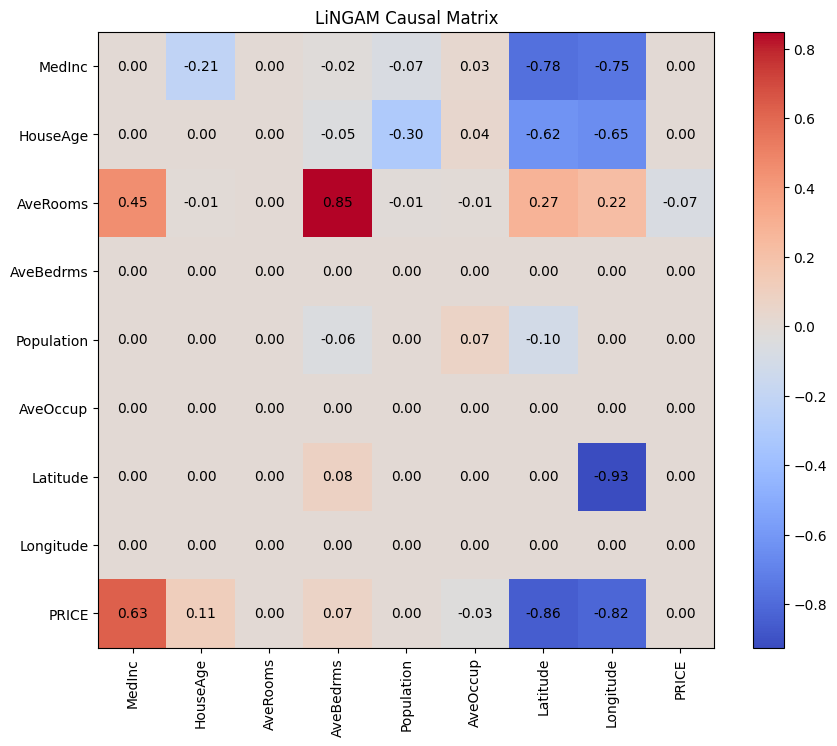

In [32]:
# LiNGAMモデルの実行
model = DirectLiNGAM()
model.fit(df_scaled)

# 係数行列を取得
causal_matrix = model.adjacency_matrix_

# 結果の可視化
plt.figure(figsize=(10, 8))
plt.imshow(causal_matrix, cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=np.arange(len(df_scaled.columns)), labels=df_scaled.columns, rotation=90)
plt.yticks(ticks=np.arange(len(df_scaled.columns)), labels=df_scaled.columns)
plt.title("LiNGAM Causal Matrix")

# 係数行列の値を表示
for (i, j), val in np.ndenumerate(causal_matrix):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')
    
plt.show()


- MedInc（中央値の収入）:0.63
    - プラスの影響（収入が高いほど価格が高くなる）
    - これは直感的にも納得できる関係
- HouseAge（築年数）:0.11
    - ややプラスの影響（築年数が高いほど価格がやや高くなる）
    - これはエリアの歴史的価値などが影響している可能性
- Latitude（緯度）:-0.86、Longitude（経度）:-0.82
    - 大きな負の影響
    - 地域的な要因が住宅価格に強く影響を与えている
    - 例えば、緯度・経度が住宅地の価値を決める重要な要素となっている（地理的な高級住宅地 vs 低価格エリア）
    - 南西の価格が高く、北東の価格が安い？

# VAR-LiNGAM
VARモデルとLiNGAMを組み合わせることで、時系列データに対応した、因果推論探索の手法。非ガウス性を利用して因果関係を推定する。

https://chatgpt.com/c/67af26c9-9a14-8006-8b68-678b4ea5a291

In [19]:
# !pip install pandas_datareader lingam statsmodels matplotlib

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from lingam import VARLiNGAM
from sklearn.preprocessing import StandardScaler

In [36]:
# 経済データ取得（FRED）
start_date = '2000-01-01'
end_date = '2024-01-01'
symbols = {
    'GDP': 'GDP',
    'Unemployment Rate': 'UNRATE',
    'Inflation Rate': 'CPIAUCSL',
    'Interest Rate': 'FEDFUNDS',
    'Stock Market Index': 'SP500'
}

df = pdr.get_data_fred(symbols.values(), start=start_date, end=end_date)
df.columns = symbols.keys()

# データの月次変化率を計算
df = df.pct_change().dropna()

# 標準化
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled

C:\Users\fuben\AppData\Local\Temp\ipykernel_31380\3850142015.py:16: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df = df.pct_change().dropna()


,GDP,Unemployment Rate,Inflation Rate,Interest Rate,Stock Market Index
DATE,,,,,
2015-02-18,-0.064141,-0.007570,-0.144061,-0.057498,-0.064564
2015-02-19,-0.064141,-0.007570,-0.144061,-0.057498,-0.130861
2015-02-20,-0.064141,-0.007570,-0.144061,-0.057498,0.506421
2015-02-23,-0.064141,-0.007570,-0.144061,-0.057498,-0.063592
2015-02-24,-0.064141,-0.007570,-0.144061,-0.057498,0.207862
...,...,...,...,...,...
2023-12-26,-0.064141,-0.007570,-0.144061,-0.057498,0.338441
2023-12-27,-0.064141,-0.007570,-0.144061,-0.057498,0.090106
2023-12-28,-0.064141,-0.007570,-0.144061,-0.057498,-0.003890


- GDP: GDP（景気の成長を示す）
- Unemployment Rate: 失業率（労働市場の状態を示す）
- Inflation Rate: インフレ率（物価の上昇を示す）
- Interest Rate: 政策金利（中央銀行の金利政策）
- Stock Market Index: 株価指数（経済の期待を示す）

In [37]:
# VARモデルのラグ選択
model = VAR(df_scaled)
lag_selection = model.select_order(maxlags=12)
print(lag_selection.summary())

# 最適なラグを取得
selected_lag = lag_selection.aic
print(f"Selected lag: {selected_lag}")

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.9451    -0.9328*      0.3886    -0.9406*
1     -0.9510*     -0.8770     0.3863*     -0.9241
2      -0.9430     -0.8073      0.3894     -0.8936
3      -0.9482     -0.7507      0.3874     -0.8762
4      -0.9432     -0.6840      0.3894     -0.8488
5      -0.9286     -0.6077      0.3951     -0.8117
6      -0.9455     -0.5629      0.3885     -0.8061
7      -0.9382     -0.4938      0.3913     -0.7763
8      -0.9389     -0.4329      0.3911     -0.7545
9      -0.9332     -0.3655      0.3933     -0.7264
10     -0.9267     -0.2973      0.3959     -0.6974
11     -0.9184     -0.2273      0.3992     -0.6666
12     -0.9464     -0.1935      0.3882     -0.6721
--------------------------------------------------
Selected lag: 1


c:\Users\fuben\.pyenv\pyenv-win\versions\3.10.5\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


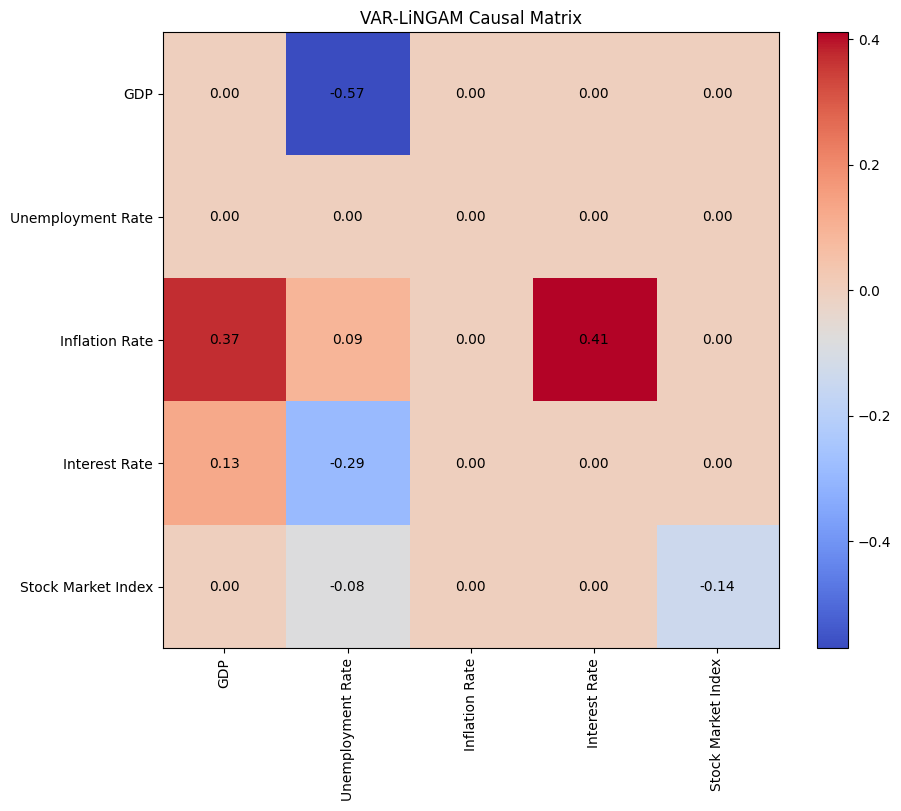

In [40]:
# VAR-LiNGAMの適用
var_lingam = VARLiNGAM(lags=selected_lag)
var_lingam.fit(df_scaled)

# 因果関係の推定結果を取得
causal_matrix = var_lingam.adjacency_matrices_

# 結果の可視化
plt.figure(figsize=(10, 8))
plt.imshow(causal_matrix.sum(axis=0), cmap="coolwarm", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=np.arange(len(df_scaled.columns)), labels=df_scaled.columns, rotation=90)
plt.yticks(ticks=np.arange(len(df_scaled.columns)), labels=df_scaled.columns)
plt.title("VAR-LiNGAM Causal Matrix")

# 係数行列の値を表示
for (i, j), val in np.ndenumerate(causal_matrix.sum(axis=0)):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

plt.show()

- GDP → 失業率（-0.57）
    - 負の影響：GDPが成長すると、失業率が下がる
    - これは経済の基本的な関係で、GDP成長によって雇用が増えるため、失業率が減ることを示唆
- インフレ率 → GDP（0.37）
    - 正の影響：インフレ率が上がると、GDPが成長
    - これは、インフレが発生すると短期的には企業の収益が増え、経済が活発になる可能性を示す
- インフレ率 → 金利（0.41）
    - 強い正の影響：インフレが上昇すると、金利も上がる
    - これは中央銀行がインフレ抑制のために金利を引き上げる典型的なパターンを示している
- 金利 → 失業率（-0.29）
    - 負の影響：金利が上がると、失業率が減る
    - これは直感に反する結果だが、特定の時期（例えば金融緩和の影響）では成り立つ可能性もあるため、さらなる分析が必要
- 株式市場 → 自身（-0.14）
    - 自己相関的な要素があり、時系列の影響が強い